<a href="https://colab.research.google.com/github/udAAbu/JSL_Project/blob/main/Pretraining_on_KL_grade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## KL_grade prediction
- using raw images to predict **KL_grade**.
- transfer the learned model to predict **joint space loss**.
- expect to get more efficient training on JSL prediction and better feature learning.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import time
import os
import copy
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore")

plt.ion()
pd.set_option("display.max_colwidth", None)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Path

- These paths should be changed to the paths in your google drive.

In [6]:
# Joint space loss CSV file
JSL_path = "/content/drive/MyDrive/OAI_data/JSL.csv"
Image_dir = "/content/drive/MyDrive/OAI_data/complete_images/"

In [8]:
JSL_data = pd.read_csv(JSL_path)
available_images = os.listdir(Image_dir)

JSL_data['Img_id'] = JSL_data.apply(lambda x: x['ID'] + '.png', axis = 1)
JSL_data["Img_path"] = JSL_data.apply(lambda x: Image_dir + x['Img_id'], axis = 1)

#filter out those records without KL_grade label or without images
table = JSL_data[(JSL_data['Img_id'].isin(available_images)) & (JSL_data['BL_KL_grade'].isna() == False)]
table.head()

,ID,Age,Sex,BMI,Race,BL_KL_grade,Knee_Injury,Alignmnet_TRIN,Alignment_degree,JSL_Prog,Img_id,Img_path
0,9001897_1,72,1,25.9,1.0,3.0,1.0,1.0,6.0,1.0,9001897_1.png,/content/drive/MyDrive/OAI_data/complete_images/9001897_1.png
1,9002116_1,61,1,36.5,2.0,2.0,0.0,1.0,4.0,1.0,9002116_1.png,/content/drive/MyDrive/OAI_data/complete_images/9002116_1.png
2,9003380_2,64,1,33.1,1.0,1.0,0.0,1.0,5.0,1.0,9003380_2.png,/content/drive/MyDrive/OAI_data/complete_images/9003380_2.png
3,9004905_2,66,2,36.2,2.0,2.0,0.0,2.0,-3.0,1.0,9004905_2.png,/content/drive/MyDrive/OAI_data/complete_images/9004905_2.png
4,9009957_1,75,2,26.8,1.0,2.0,0.0,0.0,0.0,1.0,9009957_1.png,/content/drive/MyDrive/OAI_data/complete_images/9009957_1.png


In [11]:
def train_val_test(table, test_size, val_size):

    X_train, X_test, y_train, y_test = train_test_split(table['Img_path'], table['BL_KL_grade'], test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(table, test_size = 500, val_size = 500)

data_dict = {
    "train": {"images": X_train, "labels": y_train},
    "val": {"images": X_val, "labels": y_val},
    "test": {"images":X_test, "labels": y_test}
}

In [15]:
class KL_Dataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images.tolist()
        self.labels = labels.tolist()
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        KL_grade = torch.tensor(self.labels[idx], dtype = torch.int64)
        return img, KL_grade

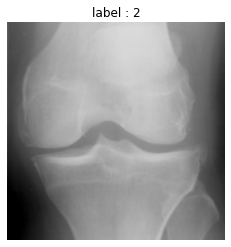

In [16]:
train_dataset = KL_Dataset(X_train, y_train, transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]))

temp_img, temp_lab = train_dataset[2]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title("label : " + str(temp_lab.item()))
plt.axis('off')
plt.show()

In [17]:
def imshow(inp, title=None, unnormalize = False):
    """
    Helper function to visualize one batch of image tensor
    """
    inp = inp.numpy().transpose((1, 2, 0))

    if unnormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    plt.imshow(inp, cmap = plt.cm.bone)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [21]:
def load_data(data, normalize = False, show_images = True):
    """
    loading data into dataloaders
    
    data: the dictionary that contains all the train/val/test
    normalize: whether to normalize image by ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    show_images: whether to show one batch of images
    """
    if normalize:
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
    else:
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
        }
    
    image_datasets = {x: KL_Dataset(data[x]['images'], data[x]['labels'], data_transforms[x]) \
                      for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

    dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) \
                   for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

    if show_images:
        if normalize == True:
            # Get a batch of training data
            img_inputs, classes = next(iter(dataloaders['train']))
            # Make a grid from batch
            out = torchvision.utils.make_grid(img_inputs)
            imshow(out, title=[str(x.item()) for x in classes], unnormalize = True)
        else:
            # Get a batch of training data
            img_inputs, classes = next(iter(dataloaders['train']))
            # Make a grid from batch
            out = torchvision.utils.make_grid(img_inputs)
            imshow(out, title=[str(x.item()) for x in classes])

    return dataloaders, dataset_sizes, image_datasets

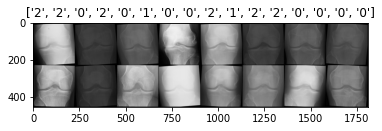

In [22]:
dataloaders, dataset_sizes, image_datasets = load_data(data_dict, normalize = False, show_images = True)

In [23]:
def get_vgg_model():
    model_ft = models.vgg16(pretrained = True)
    model_ft.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model_ft.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 5),
    )

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model_ft.parameters(), lr = 0.0001)

    # Decay LR by a factor of 0.5 every 5 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose = True)

    return model_ft.to(device), criterion, optimizer, scheduler

In [40]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                output_score, y_true = [], []

            running_loss = 0.0
            running_corrects = 0
            correct_list = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # output logits (action)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim = 1)
                    batch_correct = preds == labels.data
                    # compute loss over logits
                    batch_loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += batch_loss.item() * inputs.shape[0]
                correct_list += batch_correct.cpu().numpy().tolist()

                # clear cache
                del inputs, labels, outputs, batch_loss, batch_correct
                torch.cuda.empty_cache()

            if phase == 'train':
                scheduler.step()

            # train/val epoch average loss
            epoch_loss = running_loss / dataset_sizes[phase]
            # train/val epoch accuracy
            epoch_acc = np.mean(correct_list)

            if phase == 'val':
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                phase, epoch_loss, epoch_acc))
                val_acc_history.append(epoch_acc)
            else:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                phase, epoch_loss, epoch_acc))
                train_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
            #if phase == 'val' and epoch_loss < model_score:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [34]:
def eval_model(model, criterion, eval_set = 'val'):
    model.eval()

    since = time.time()
    loss_eval, acc_eval= 0, 0

    # y_hat: predictions
    # output_score: probabilities (compute AUC)
    # y_true: ground truth
    y_hat, y_true = [], []
    
    test_batches = len(dataloaders[eval_set])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[eval_set]):
        if i % 100 == 0:
            print("\rbatch {}/{}".format(i, test_batches), end='', flush=True)
            
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, dim = 1)
        # is_correct: 1 if correct else 0
        is_correct = preds == labels.data
        batch_loss = criterion(outputs, labels)

        loss_eval += batch_loss.item() * inputs.shape[0]
        acc_eval += torch.sum(is_correct)

        y_true += labels.cpu().detach().numpy().tolist()
        y_hat += preds.cpu().numpy().tolist()

        del inputs, labels, outputs, batch_loss
        torch.cuda.empty_cache()
        
    avg_loss = loss_eval/ dataset_sizes[eval_set]
    avg_acc = acc_eval / dataset_sizes[eval_set]

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

    cm = confusion_matrix(y_true, y_hat)
    df_cm = pd.DataFrame(cm, index = [0, 1, 2, 3, 4], columns = [0, 1, 2, 3, 4])
    plt.figure(figsize = (8, 6))
    sns.heatmap(df_cm, annot=True, fmt='.5g')
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.title("confusion matrix")
    plt.show()

    return y_true, y_hat

In [51]:
model_ft, criterion, optimizer, scheduler = get_vgg_model()
summary(model_ft, (3, 224, 224))

Adjusting learning rate of group 0 to 1.0000e-04.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]      

In [52]:
best_model, train_acc_hist, val_acc_hist = train_model(model_ft, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 1.1319 Acc: 0.5155
val Loss: 0.9526 Acc: 0.6360
Epoch 1/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.8682 Acc: 0.6409
val Loss: 0.7651 Acc: 0.6960
Epoch 2/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.7588 Acc: 0.6837
val Loss: 0.7726 Acc: 0.6840
Epoch 3/9
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.7173 Acc: 0.6988
val Loss: 0.7664 Acc: 0.7000
Epoch 4/9
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.6667 Acc: 0.7215
val Loss: 0.7335 Acc: 0.7020
Epoch 5/9
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.5788 Acc: 0.7539
val Loss: 0.7086 Acc: 0.7340
Epoch 6/9
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.5404 Acc: 0.7751
val Loss: 0.7601 Acc: 0.6860
Epoch 7/9
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 

Evaluating model
----------
batch 0/32
Evaluation completed in 0m 6s
Avg loss (test): 0.7565
Avg acc (test): 0.7260
----------


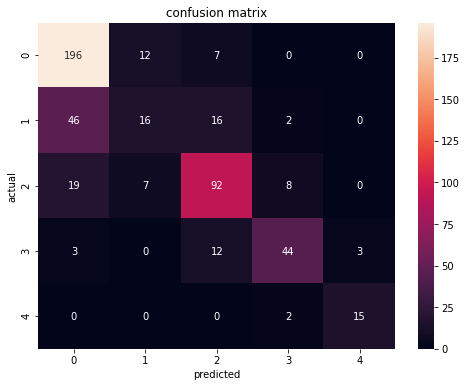

In [53]:
y_true, y_hat = eval_model(best_model, criterion, eval_set = 'test')

In [47]:
KL_model_PATH = '/content/drive/MyDrive/DL_models/KL_prediction.pt'
torch.save(model_ft.state_dict(), KL_model_PATH)